## Multivariate Analysis

### 1. Import Dependencies

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')

### 2. Data Loading

In [7]:
df = pd.read_csv('../Data/Processed/Telco_Churn_Class_Bivariate_Analysis_Done.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,BillingLevel,BillingTenureSegment,EngagementScore,EngagementSegment,BillingEngageSegment,TenureEngageSegment,IsMonthToMonth,HasCoreProtection,HighRiskFinancialProfile,OverallRiskScore
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Low,Low-New,2,LowEngage,Low-LowEngage,New-LowEngage,1,0,1,3
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Low,Low-Loyal,4,MidEngage,Low-MidEngage,Loyal-MidEngage,0,1,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Low,Low-New,4,MidEngage,Low-MidEngage,New-MidEngage,1,1,0,2
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Low,Low-Loyal,4,MidEngage,Low-MidEngage,Loyal-MidEngage,0,1,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,High,High-New,2,LowEngage,High-LowEngage,New-LowEngage,1,0,1,4


### 3. Multicollinearity Check and Feature Selection

--- 1. Correlation Matrix Heatmap ---


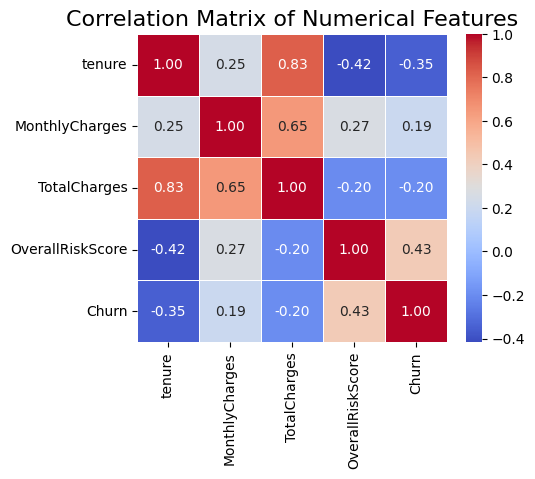


--- 2. Identifying Feature Pairs with High Correlation ---
Feature pairs with correlation stronger than 0.7:
  Feature 1     Feature 2  Correlation
0    tenure  TotalCharges     0.826178

--- 3. Variance Inflation Factor (VIF) Test ---
VIF measures how much a feature is explained by other features.
Rule of thumb: VIF > 5 indicates high multicollinearity.
            feature       VIF
0            tenure  5.950255
1    MonthlyCharges  3.670441
2      TotalCharges  9.677591
3  OverallRiskScore  1.490535


In [8]:

# --- Correlation Matrix Visualization ---
print("--- 1. Correlation Matrix Heatmap ---")
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'OverallRiskScore', 'Churn']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()


# --- Programmatic Identification of High Correlation Pairs ---
print("\n--- 2. Identifying Feature Pairs with High Correlation ---")
# We look for correlation with an absolute value greater than 0.7
threshold = 0.7
# Create a boolean mask for correlations above the threshold
high_corr_mask = (corr_matrix.abs() > threshold) & (corr_matrix.abs() < 1.0)
high_corr_pairs = corr_matrix[high_corr_mask].stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
# Remove duplicate pairs (e.g., (A, B) is same as (B, A))
high_corr_pairs['sorted_features'] = high_corr_pairs.apply(lambda row: tuple(sorted((row['Feature 1'], row['Feature 2']))), axis=1)
high_corr_pairs = high_corr_pairs.drop_duplicates(subset='sorted_features').drop(columns='sorted_features')

if high_corr_pairs.empty:
    print(f"No feature pairs found with correlation stronger than {threshold}")
else:
    print(f"Feature pairs with correlation stronger than {threshold}:")
    print(high_corr_pairs)


# --- Advanced Multicollinearity Test (Variance Inflation Factor - VIF) ---
print("\n--- 3. Variance Inflation Factor (VIF) Test ---")
print("VIF measures how much a feature is explained by other features.")
print("Rule of thumb: VIF > 5 indicates high multicollinearity.")

# Select only the predictor variables (independent features)
X = df[[col for col in numerical_cols if col != 'Churn']]
# VIF requires a constant (intercept) to be added
X_with_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X.columns))]

print(vif_data)



In this section, we analyze the relationships between our numerical predictor variables to identify potential multicollinearity. This is a crucial step to ensure we build a robust and interpretable model.

#### Summary of Findings

Our analysis used two methods to check for multicollinearity: a correlation matrix and the Variance Inflation Factor (VIF) test. Both methods led to the same conclusion.

- **High Correlation Identified**: The correlation matrix revealed a very strong positive correlation between `tenure` and `TotalCharges` (r = 0.83).
- **VIF Confirms Multicollinearity**: The VIF test confirmed this finding. Both `tenure` (VIF ≈ 5.95) and `TotalCharges` (VIF ≈ 9.68) had scores well above the standard threshold of 5, indicating significant multicollinearity.

#### The Decision: Removing `TotalCharges`

While advanced tree-based models can handle multicollinearity without a significant drop in accuracy, it negatively impacts model interpretability by "diluting" the importance across redundant features. To create a simpler and more explainable model, it is best practice to remove one of the highly correlated variables.

**Based on this analysis, we will remove the `TotalCharges` feature.**

**Reasoning for this choice:**

- **`tenure` is the Cause, `TotalCharges` is the Effect**: `tenure` is a more fundamental feature that directly measures customer loyalty and time with the company. `TotalCharges` is largely a result of a customer's `tenure`. For predictive modeling, it is better to keep the root cause.

- **Improved Interpretability**: Keeping `tenure` allows for clearer business insights. It is more actionable to say "customers with low tenure are at risk" than to say "customers with low total charges are at risk," as the latter is merely a symptom of the former.

By removing `TotalCharges`, we create a more robust and interpretable model without losing significant predictive information, as the core concept of customer longevity is still captured by the `tenure` feature.


In [9]:
# Create a copy of the DataFrame 
df_copy = df.copy()

# Drop the 'TotalCharges' column from the new copy
df_copy.drop(columns=['TotalCharges'], inplace=True)



### 4. Feature Interaction Analysis



While bivariate analysis helps assess individual feature impact on churn, it doesn't capture how features combine to influence behavior. Feature interaction analysis enables us to explore these joint effects and uncover high-risk customer sub-segments.

Although tree-based models like XGBoost can automatically detect feature interactions, performing this analysis helps us interpret the complex patterns such models are likely to identify. Our goal here is to extract actionable business insights—not necessarily to create new features.

We focus on two high-impact feature interactions identified during bivariate analysis:

---

#### Interaction 1: **Contract** × **PaymentMethod**

- **Rationale:** Customers with *Month-to-month* contracts and *Electronic check* payments were individually strong churn predictors.
- **Hypothesis:** These two characteristics together may amplify churn risk. The flexibility of a short contract combined with a less "sticky" payment method likely forms a particularly vulnerable segment.
- **Implication:** This analysis also supports our earlier engineered feature, `HighRiskFinancialProfile`.

---

#### Interaction 2: **InternetService** × **HasCoreProtection**

- **Rationale:** *Fiber optic* internet is associated with high churn, while customers with *HasCoreProtection* (OnlineSecurity or TechSupport) exhibit better retention.
- **Hypothesis:** Core protection services may offset the churn risk of fiber optic users.
- **Implication:** Findings here could inform targeted retention strategies loyalty.

---


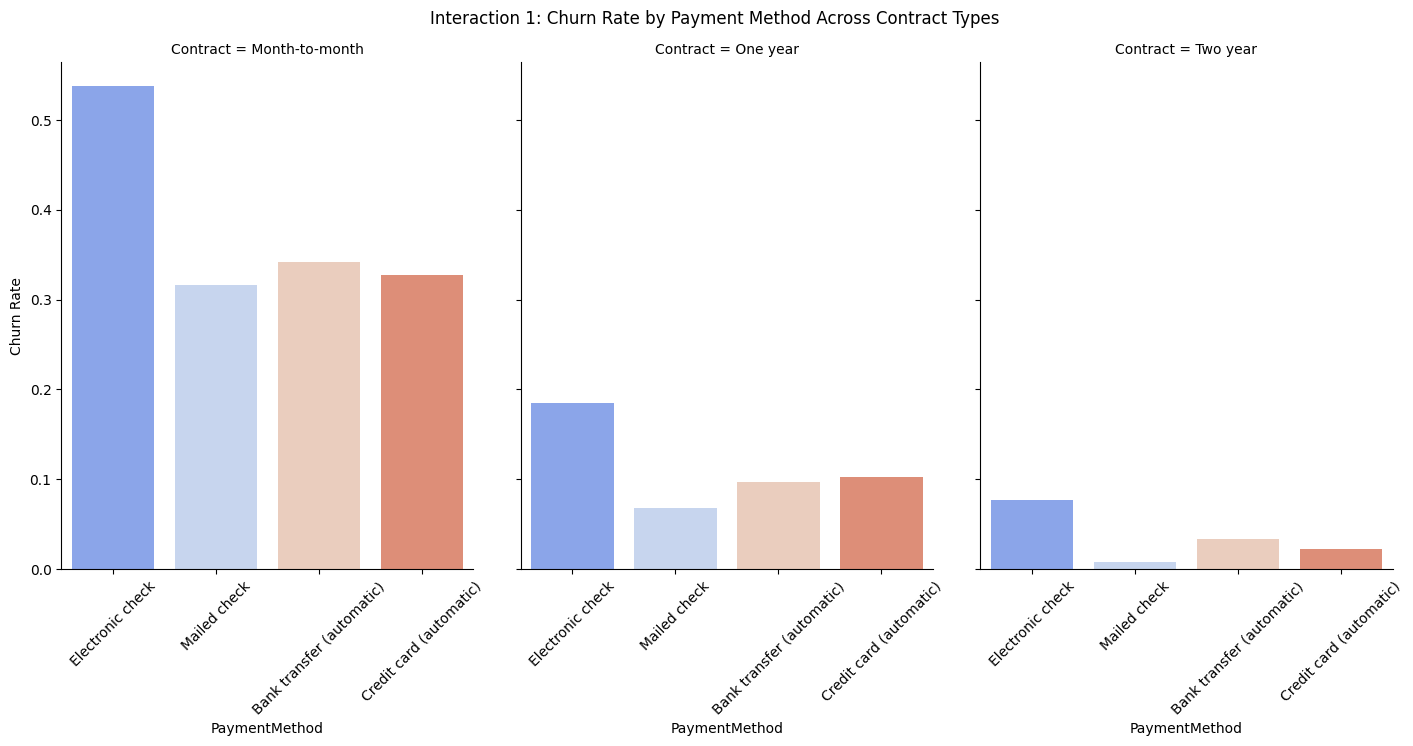

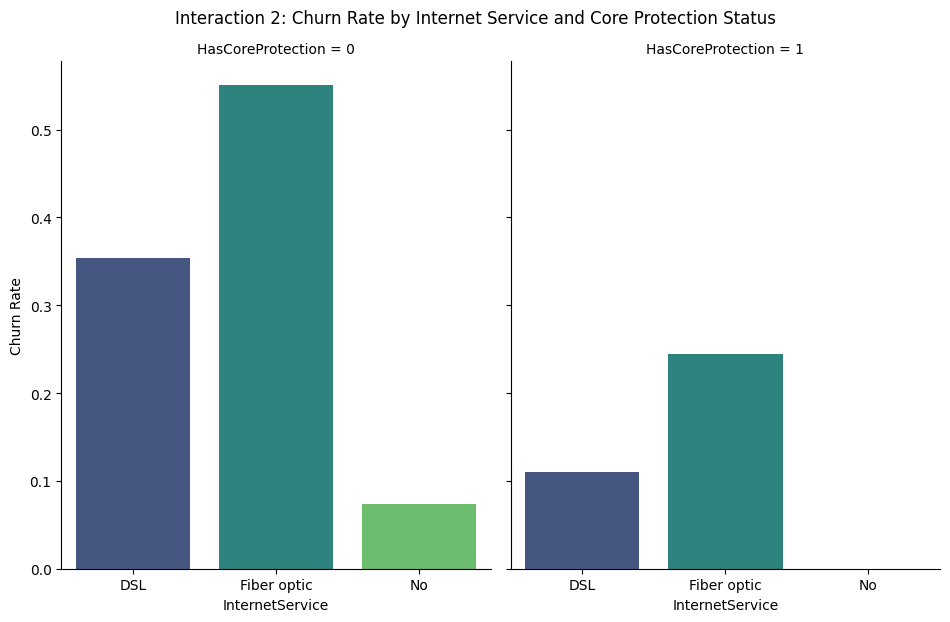

In [10]:
# Interaction 1: Contract vs. PaymentMethod
g1 = sns.catplot(data=df_copy, x='PaymentMethod', y='Churn', col='Contract', 
                 kind='bar', height=6, aspect=0.8, palette='coolwarm', errorbar=None)
g1.fig.suptitle('Interaction 1: Churn Rate by Payment Method Across Contract Types', y=1.03)
g1.set_xticklabels(rotation=45)
g1.set_ylabels("Churn Rate")
plt.show()


# Interaction 2: InternetService vs. HasCoreProtection
g2 = sns.catplot(data=df_copy, x='InternetService', y='Churn', col='HasCoreProtection',
                 kind='bar', height=6, aspect=0.8, palette='viridis', errorbar=None)
g2.fig.suptitle('Interaction 2: Churn Rate by Internet Service and Core Protection Status', y=1.03)
g2.set_xticklabels(rotation=0)
g2.set_ylabels("Churn Rate")
# Customizing column titles for clarity
g2.set_titles("HasCoreProtection = {col_name}")
plt.show()

#### Multivariate Analysis: Business Insights from Feature Interactions

Our interaction analysis has successfully uncovered deeper, more nuanced patterns that go beyond individual feature effects. By examining how key predictors work in combination, we have identified specific, high-risk customer sub-segments and discovered clear, actionable strategic insights.

---

#### Insight 1: The **"Low-Commitment" Customer Profile**

**Analysis:**  
The interaction between **Contract type** and **PaymentMethod** revealed a powerful synergistic effect.

While using **Electronic check** is associated with higher churn across all contract types, this risk is **massively amplified** for customers on a **Month-to-month** contract.

>  The churn rate for this specific combination exceeds **50%**, far higher than:
> - Any other payment method within Month-to-month contracts
> - Electronic check users on longer-term contracts

**Business Implication:**  
We have identified a clear **"low-commitment" customer profile**—customers with minimal ties to our service, both contractually and financially. This group constitutes a **major churn segment** and demands targeted intervention.

This insight also **validates our engineered feature**: `HighRiskFinancialProfile`.

---

#### Insight 2: **Core Services Are the "Antidote" for Fiber Optic Churn**

**Analysis:**  
The interaction between **InternetService** and **HasCoreProtection** uncovered a critical insight.

The high churn rate associated with **Fiber optic** customers is largely concentrated among those **without** core protection services.

>  For Fiber optic users **with HasCoreProtection** (OnlineSecurity or TechSupport), **churn drops by over 50%** compared to those without.

**Business Implication:**  
This suggests that the issue with Fiber optic churn is **not the product itself**, but the **absence of value-added protective services**.

**Strategic Recommendation:**  
Launch a targeted marketing campaign to **cross-sell OnlineSecurity and TechSupport** to existing Fiber optic customers. This could be the **single most impactful strategy** for reducing churn in one of our most valuable segments.

---


In [11]:
df_copy.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'Churn', 'is_new_customer',
       'TenureSegment', 'ServiceUsage', 'BillingLevel', 'BillingTenureSegment',
       'EngagementScore', 'EngagementSegment', 'BillingEngageSegment',
       'TenureEngageSegment', 'IsMonthToMonth', 'HasCoreProtection',
       'HighRiskFinancialProfile', 'OverallRiskScore'],
      dtype='object')

### 5. Multivariate Analysis: Customer Segmentation 
Our final analysis step is to use K-Means clustering to group customers into distinct segments based on their behavior. The goal is to discover natural groupings without using the Churn label, and then analyze which segments are most at risk.

To ensure the algorithm can find detailed patterns based on specific service combinations, we will use a comprehensive feature set.

#### Final Features for Clustering:
Core Behaviors: tenure, MonthlyCharges, Contract, PaymentMethod, PaperlessBilling

Individual Services: InternetService, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

#### Process:
Preprocess: One-hot encode all categorical features and scale the entire dataset.

Find k: Use the Elbow Method to determine the optimal number of clusters.

Segment & Analyze: Run K-Means to assign segments and then analyze the churn rate for each resulting customer persona.


#### 5.1 Create the Data Frame for clustering


In [12]:
behavioral_features = ['tenure', 'MonthlyCharges', 'Contract', 'PaymentMethod', 
                        'PaperlessBilling', 'InternetService', 'MultipleLines', 'OnlineSecurity',
                        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
                        ]

df_cluster = df_copy[behavioral_features]

df_cluster.head(5)

,tenure,MonthlyCharges,Contract,PaymentMethod,PaperlessBilling,InternetService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,1,29.85,Month-to-month,Electronic check,Yes,DSL,No phone service,No,Yes,No,No,No,No
1,34,56.95,One year,Mailed check,No,DSL,No,Yes,No,Yes,No,No,No
2,2,53.85,Month-to-month,Mailed check,Yes,DSL,No,Yes,Yes,No,No,No,No
3,45,42.30,One year,Bank transfer (automatic),No,DSL,No phone service,Yes,No,Yes,Yes,No,No
4,2,70.70,Month-to-month,Electronic check,Yes,Fiber optic,No,No,No,No,No,No,No


#### 5.2 Encode the Categorical variables

In [15]:
categorical_cols = ['Contract', 'PaymentMethod', 'PaperlessBilling', 'InternetService', 'MultipleLines', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
                    ]
df_cluster_encoded = pd.get_dummies(df_cluster, categorical_cols, prefix_sep='_')
df_cluster_encoded.head(5)


,tenure,MonthlyCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,1,29.85,True,False,False,False,False,True,False,False,...,False,True,False,False,True,False,False,True,False,False
1,34,56.95,False,True,False,False,False,False,True,True,...,True,True,False,False,True,False,False,True,False,False
2,2,53.85,True,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,True,False,False
3,45,42.30,False,True,False,True,False,False,False,True,...,True,False,False,True,True,False,False,True,False,False
4,2,70.70,True,False,False,False,False,True,False,False,...,False,True,False,False,True,False,False,True,False,False


#### 5.3 Scale features

In [26]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_cluster_encoded)
df_cluster_scaled = pd.DataFrame(scaled_array, columns=df_cluster_encoded.columns)




In [27]:
df_cluster_scaled

,tenure,MonthlyCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,-1.277445,-1.160323,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807,-0.829798,...,-0.723968,1.013869,-0.525927,-0.639439,1.227357,-0.525927,-0.790132,1.236489,-0.525927,-0.796070
1,0.066327,-0.259629,-1.105970,1.944582,-0.562975,-0.529885,-0.525047,-0.711026,1.835513,1.205113,...,1.381277,1.013869,-0.525927,-0.639439,1.227357,-0.525927,-0.790132,1.236489,-0.525927,-0.796070
2,-1.236724,-0.362660,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,-0.711026,1.835513,-0.829798,...,-0.723968,1.013869,-0.525927,-0.639439,1.227357,-0.525927,-0.790132,1.236489,-0.525927,-0.796070
3,0.514251,-0.746535,-1.105970,1.944582,-0.562975,1.887201,-0.525047,-0.711026,-0.544807,1.205113,...,1.381277,-0.986321,-0.525927,1.563872,1.227357,-0.525927,-0.790132,1.236489,-0.525927,-0.796070
4,-1.236724,0.197365,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807,-0.829798,...,-0.723968,1.013869,-0.525927,-0.639439,1.227357,-0.525927,-0.790132,1.236489,-0.525927,-0.796070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.340876,0.665992,-1.105970,1.944582,-0.562975,-0.529885,-0.525047,-0.711026,1.835513,-0.829798,...,1.381277,-0.986321,-0.525927,1.563872,-0.814759,-0.525927,1.265612,-0.808742,-0.525927,1.256171
7039,1.613701,1.277533,-1.105970,1.944582,-0.562975,-0.529885,1.904590,-0.711026,-0.544807,-0.829798,...,1.381277,1.013869,-0.525927,-0.639439,-0.814759,-0.525927,1.265612,-0.808742,-0.525927,1.256171
7040,-0.870241,-1.168632,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807,-0.829798,...,-0.723968,1.013869,-0.525927,-0.639439,1.227357,-0.525927,-0.790132,1.236489,-0.525927,-0.796070
7041,-1.155283,0.320338,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,-0.711026,1.835513,-0.829798,...,-0.723968,1.013869,-0.525927,-0.639439,1.227357,-0.525927,-0.790132,1.236489,-0.525927,-0.796070


#### 5.4 Find Optimal K using Elbow Method

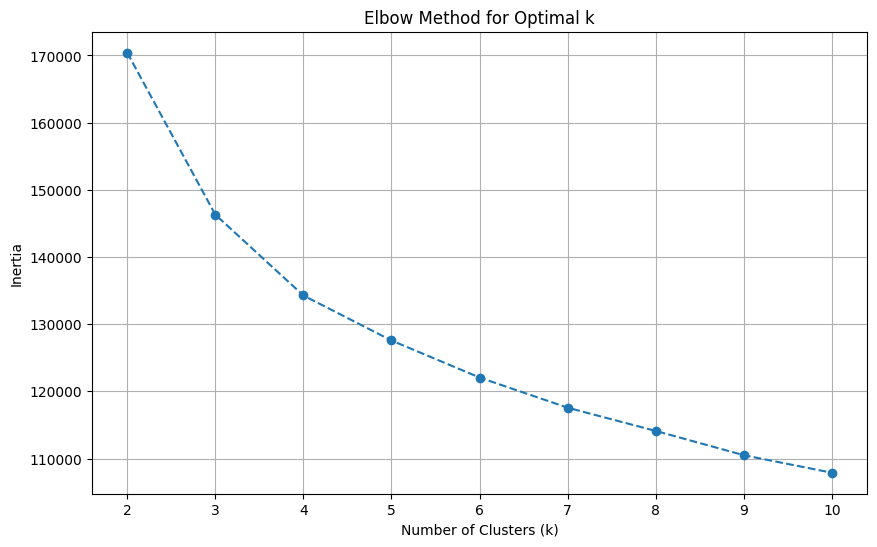

In [28]:

inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method chart
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

#### Customer Segmentation: Determining the Optimal Number of Clusters

To identify the optimal number of customer segments, we applied the **Elbow Method** using the K-Means clustering algorithm. This method evaluates how the *inertia* (sum of squared distances to the nearest cluster center) changes as the number of clusters (*k*) increases.

#### Elbow Method Analysis

We ran K-Means for values of *k* ranging from 2 to 10 and plotted the corresponding inertia scores. The resulting **Elbow Plot** shows a noticeable "elbow" at **k = 4**.

- For *k* values from **2 to 4**, the inertia drops sharply, indicating that each additional cluster captures significant structure in the data.
- After **k = 4**, the rate of decrease slows considerably, suggesting diminishing returns from adding more clusters.

#### Conclusion

Based on the Elbow Method, the optimal number of customer segments is **four (k = 4)**. This provides a balance between capturing key behavioral differences and avoiding over-segmentation.


#### 5.5 Cluster Profiling

Now, we have grouped customers into 4 clusters, we need to understand what each segment represents. By analyzing the average values and most common chices for the features within each cluster, we can create descriptive personas. This helps us to move from abstract cluster labels to actionable business insights about which customer profiles are most at risk of churning.

--- Customer Segment Profiles ---


,tenure,MonthlyCharges,Contract,PaymentMethod,PaperlessBilling,InternetService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
Cluster,,,,,,,,,,,,,
0,57.127874,89.868929,Two year,Bank transfer (automatic),Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,21.132698,49.788286,Month-to-month,Electronic check,Yes,DSL,No,No,No,No,No,No,No
2,30.547182,21.079194,Two year,Mailed check,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
3,21.413617,85.825336,Month-to-month,Electronic check,Yes,Fiber optic,Yes,No,No,No,No,No,No



--- Churn Rate by Customer Segment ---
Cluster
0    10.656197
1    26.158730
2     7.404980
3    53.450672
Name: Churn, dtype: float64


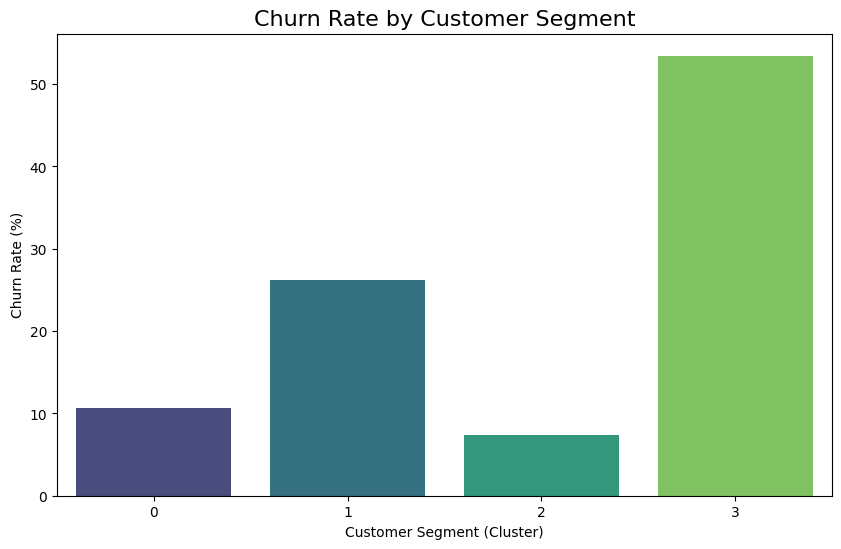

In [29]:

# 1. Run K-Means with our optimal k=4
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans.fit(df_cluster_scaled)

# 2. Assign the cluster labels back to our original DataFrame
df_copy['Cluster'] = kmeans.labels_

# 3. Profile the Clusters
# We will group by the cluster label and find the mean for numerical features
# and the mode for categorical features to understand the "typical" customer in each segment.

# Select original features used for clustering to create the profile
profile_features = behavioral_features 
cluster_profile = df_copy.groupby('Cluster')[profile_features].agg(
    lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
)

print("--- Customer Segment Profiles ---")
display(cluster_profile)


# 4. Analyze Churn Rate per Segment
print("\n--- Churn Rate by Customer Segment ---")
churn_by_cluster = df_copy.groupby('Cluster')['Churn'].mean() * 100
print(churn_by_cluster)

# Visualize the churn rate per cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_cluster.index, y=churn_by_cluster.values, palette='viridis')
plt.title('Churn Rate by Customer Segment', fontsize=16)
plt.xlabel('Customer Segment (Cluster)')
plt.ylabel('Churn Rate (%)')
plt.show()

#### Summary of Customer Segments

Based on K-Means clustering, we identified **four distinct customer personas**, each with unique behaviors and churn tendencies. This segmentation enables targeted strategies to improve retention and engagement.

---
#### Cluster 3: High-Risk "Trial" Users  
- **Churn Rate:** 53.5% (Extremely High)  
- **Profile:**  
  - New customers with **low tenure**  
  - Subscribe to **Fiber optic** service  
  - On **Month-to-month contracts**  
  - Pay via **Electronic check**  
  - Minimal or no add-on services  
- **Insight:**  
  This segment consists of customers who are likely *trying out* the best service with minimal commitment. They are highly volatile and present the greatest churn risk.

---

#### Cluster 1: At-Risk "Basic" Users  
- **Churn Rate:** 26.1% (High)  
- **Profile:**  
  - Also new customers with **low tenure**  
  - Use **DSL internet service**  
  - On **Month-to-month contracts**  
  - No add-on services  
- **Insight:**  
  These customers are also low-commitment but on more basic plans. While less risky than Cluster 3, they still represent a significant churn risk.

---

#### Cluster 0: Loyal "Power Users"  
- **Churn Rate:** 10.6% (Very Low)  
- **Profile:**  
  - Long-tenure customers  
  - On **Two-year contracts**  
  - Use **Fiber optic** internet  
  - Subscribe to **multiple add-on services**  
- **Insight:**  
  This is your most valuable segment — highly engaged, fully committed, and extremely loyal.

---

#### Cluster 2: Stable "No-Frills" Customers  
- **Churn Rate:** 7.4% (Lowest)  
- **Profile:**  
  - Long-tenure customers  
  - On **Two-year contracts**  
  - **No internet service**  
  - Low monthly charges  
- **Insight:**  
  A highly stable group, likely retained due to simplicity and long-term contracts. They present the lowest churn risk.

---

#### Conclusion

This clustering analysis clearly demonstrates that **customer behavior and loyalty can be segmented into meaningful personas**, each with distinct churn patterns. These insights are crucial for implementing personalized retention strategies and improving overall customer lifetime value.


In [30]:
df_copy.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,BillingTenureSegment,EngagementScore,EngagementSegment,BillingEngageSegment,TenureEngageSegment,IsMonthToMonth,HasCoreProtection,HighRiskFinancialProfile,OverallRiskScore,Cluster
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Low-New,2,LowEngage,Low-LowEngage,New-LowEngage,1,0,1,3,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Low-Loyal,4,MidEngage,Low-MidEngage,Loyal-MidEngage,0,1,0,1,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Low-New,4,MidEngage,Low-MidEngage,New-MidEngage,1,1,0,2,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Low-Loyal,4,MidEngage,Low-MidEngage,Loyal-MidEngage,0,1,0,1,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,High-New,2,LowEngage,High-LowEngage,New-LowEngage,1,0,1,4,3


In [31]:
df_copy.to_csv('../Data/Processed/Telco_Churn_Class_Multivariate_Analysis_Done.csv', index=False)